<a href="https://colab.research.google.com/github/pixelwizard2/Project.AI--GuardianPay---Protecting-Against-Lost-Card-and-Copied-Card-Transactions/blob/main/GuardianPay_code_(%ED%95%9C%EA%B5%AD%EC%96%B4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GuardianPay Project : 카드 결제 이상 행위 감지 및 보호 프로그램
* 신용 카드 거래 데이터셋 : https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions

## 1. Google Drive 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. 데이터 파일 읽어오기

In [2]:
import pandas as pd

# 데이터 파일 경로 설정
cards_file_path = '/content/drive/My Drive/sd254_cards.csv'
users_file_path = '/content/drive/My Drive/sd254_users.csv'
transactions_file_path = '/content/drive/My Drive/User0_credit_card_transactions.csv'

# 데이터 파일을 데이터프레임으로 읽어오기
cards_df = pd.read_csv(cards_file_path)
users_df = pd.read_csv(users_file_path)
transactions_df = pd.read_csv(transactions_file_path)

## 3. 데이터프레임 확인

In [3]:
print("Cards Dataframe:")
cards_df.head()

Cards Dataframe:


,User,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,1,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,0,2,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,0,3,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,0,4,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [4]:
print("Users Dataframe:")
users_df.head()

Users Dataframe:


,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1


In [5]:
print("\nTransactions Dataframe:")
transactions_df.head()


Transactions Dataframe:


,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


## 4. 데이터 프레임 병합 후 전처리

### 4.1 데이터셋 병합

 거래 내역과 카드 정보를 'User'와 'CARD INDEX'를 기준으로 병합합니다.

In [6]:
# 'cards_df'에 더미 값(예: 0)을 가진 'Is Fraud?' 컬럼 추가
cards_df['Is Fraud?'] = 0

# 'transactions_df'와 'cards_df'를 'User'와 'Card' 컬럼을 기준으로 병합
merged_data = pd.merge(
    transactions_df,
    cards_df.drop(columns=['Is Fraud?']),  # 'Is Fraud?' 컬럼을 제외하고 가져옵니다.
    left_on=['User', 'Card'],
    right_on=['User', 'CARD INDEX'],
    how='left',
    suffixes=('_transactions', '_cards')
)

# 데이터 병합이 완료된 merged_data 데이터프레임 출력
merged_data.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No


In [7]:
# 'merged_data' 데이터프레임의 컬럼 이름 확인
merged_data.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?', 'CARD INDEX', 'Card Brand', 'Card Type',
       'Card Number', 'Expires', 'CVV', 'Has Chip', 'Cards Issued',
       'Credit Limit', 'Acct Open Date', 'Year PIN last Changed',
       'Card on Dark Web'],
      dtype='object')

In [8]:
# 'Is Fraud?' 컬럼의 고유한 값 확인(* 통합 과정에서 Yes/No 데이터가 NaN으로 변형 안 되도록 미리 체크하는 부분)
unique_values = merged_data['Is Fraud?'].unique()
print(unique_values)

# 'Is Fraud?' 컬럼 값이 'YES'인 데이터 개수
num_yes = (merged_data['Is Fraud?'] == 'Yes').sum()

# 'Is Fraud?' 컬럼 값이 'NO'인 데이터 개수
num_no = (merged_data['Is Fraud?'] == 'No').sum()

print("count Yes:", num_yes)
print("count No:", num_no)



['No' 'Yes']
count Yes: 27
count No: 19936


### 4.2 병합된 데이터셋 전처리

1) 거래 금액의 문자열을 숫자형으로 변환합니다.

2) 거래 날짜와 시간을 datetime 형식으로 변환합니다.

3) 사기 여부를 숫자형으로 변환합니다.

4) 필요한 컬럼을 선택하여 새로운 데이터프레임을 생성합니다.

In [9]:
# 'Is Fraud?' 컬럼의 'NaN' 값을 'No'로 미리 대체
merged_data['Is Fraud?'].fillna('No', inplace=True)

# 'Is Fraud?' 컬럼을 숫자형으로 변환합니다.
# map 메소드를 사용하여 'Yes'와 'No'를 각각 1과 0으로 변환합니다.
merged_data['Is Fraud?'] = merged_data['Is Fraud?'].map({'Yes': 1, 'No': 0})

# 변환된 'Is Fraud?' 컬럼 값 확인
print(merged_data['Is Fraud?'].value_counts())

0    19936
1       27
Name: Is Fraud?, dtype: int64


In [19]:
# 거래 금액을 숫자형으로 변환합니다.
merged_data['Amount'] = merged_data['Amount'].replace('[\$,]', '', regex=True).astype(float)

# 'Time' 컬럼을 시간 형식으로 변환합니다.
merged_data['Datetime'] = pd.to_datetime(merged_data['Year'].astype(str) + '-' +
                                         merged_data['Month'].astype(str) + '-' +
                                         merged_data['Day'].astype(str) + ' ' +
                                         merged_data['Time'])

# 필요한 컬럼을 선택하여 새로운 데이터프레임을 생성합니다.
analyzed_data = merged_data[['Amount', 'Datetime', 'Use Chip', 'Is Fraud?', 'Time', 'Merchant City', 'Merchant State']]

# analyzed_data를 CSV 파일로 저장
# analyzed_data.to_csv('analyzed_data.csv', index=False)

# 파일 다운로드 링크 생성
# from google.colab import files
# files.download('analyzed_data.csv')

# 데이터 전처리가 완료된 analyzed_data 데이터프레임 출력
analyzed_data.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Amount,Datetime,Use Chip,Is Fraud?,Time,Merchant City,Merchant State
0,134.09,2002-09-01 06:21:00,Swipe Transaction,0,06:21,La Verne,CA
1,38.48,2002-09-01 06:42:00,Swipe Transaction,0,06:42,Monterey Park,CA
2,120.34,2002-09-02 06:22:00,Swipe Transaction,0,06:22,Monterey Park,CA
3,128.95,2002-09-02 17:45:00,Swipe Transaction,0,17:45,Monterey Park,CA
4,104.71,2002-09-03 06:23:00,Swipe Transaction,0,06:23,La Verne,CA


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5. 데이터 항목별 상관관계 탐색

병합된 데이터셋을 활용하여 '거래 발생 시간',  '사기 발생 장소',  '결제 금액' 등의 항목들을 조합하여 사기 거래와의 관계를 탐색합니다.

### **5-1. '거래 금액'과 '사기 여부' 상관 관계**

<ipython-input-11-91156a1a7bb1>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = analyzed_data.corr()


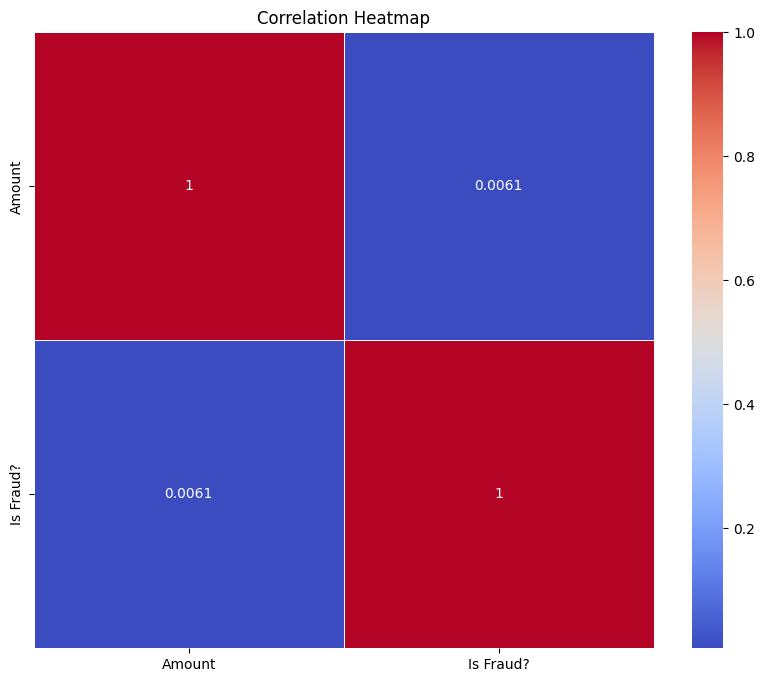

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 항목별 상관관계 계산
correlation_matrix = analyzed_data.corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

거래 금액('Amount')과 사기 여부('Is Fraud?') 간의 상관관계는 0.6%로 매우 낮으며, 두 변수 간에는 거의 선형적인 관련성이 없는 것 같습니다. 따라서 거래 금액이 사기 여부를 예측하는 데 큰 영향을 미치지 않는 것으로 판단됩니다. 그러나 높은 금액이 주로 카드 사기 결제에 해당될 수 있는 경우를 고려하여 더 자세히 분석하겠습니다.

아래와 같은 3단계의 추가 분석을 진행하겠습니다 :

금액 범주화 ▶ 시각화 ▶ 통계 분석

(1) 금액 범주화: 거래 금액을 작은 금액, 중간 금액, 높은 금액 등의 범주로 나누어 사기 여부를 조사합니다.

(2) 시각화: 각 금액 범주에서의 사기 거래 비율을 원 그래프로 시각화하여 확인합니다.

<ipython-input-21-533bfdc0045e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analyzed_data.loc[:, 'Amount Category'] = pd.cut(analyzed_data['Amount'], bins=bins, labels=labels)
<ipython-input-21-533bfdc0045e>:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  analyzed_data.loc[:, 'Amount Category'] = pd.cut(analyzed_data['Amount'], bins=bins, labels=labels)


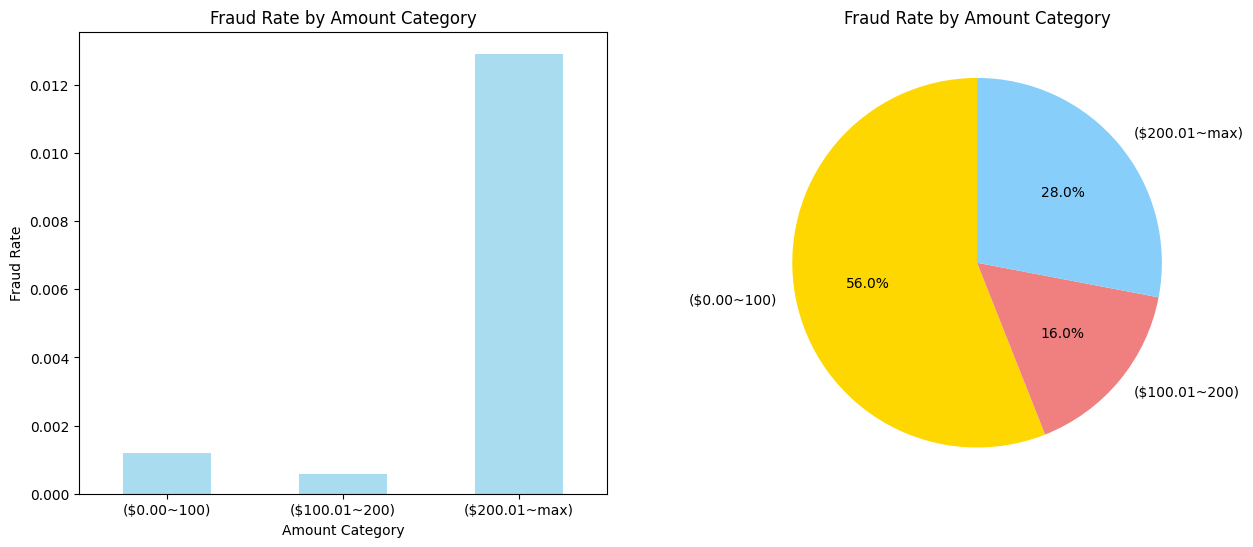

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# 금액을 작은 금액, 중간 금액, 높은 금액 범주로 나눕니다.
bins = [0, 100, 200, analyzed_data['Amount'].max()]
labels = ['($0.00~100)', '($100.01~200)', '($200.01~max)']
analyzed_data.loc[:, 'Amount Category'] = pd.cut(analyzed_data['Amount'], bins=bins, labels=labels)

# 각 금액 범주의 사기 거래 비율을 계산합니다.
fraud_rate_by_amount = analyzed_data.groupby('Amount Category')['Is Fraud?'].mean()

# 카이제곱 검정 수행
contingency_table = pd.crosstab(analyzed_data['Amount Category'], analyzed_data['Is Fraud?'])
chi2, p, _, _ = chi2_contingency(contingency_table)

# 그래프를 한 번에 그리기
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 첫 번째 그래프: 막대 그래프
fraud_rate_by_amount.plot(kind='bar', color='skyblue', alpha=0.7, ax=ax1)
ax1.set_xlabel('Amount Category')
ax1.set_ylabel('Fraud Rate')
ax1.set_title('Fraud Rate by Amount Category')

# x축 레이블 방향 설정 (가로로 출력)
ax1.tick_params(axis='x', rotation=0)

# 두 번째 그래프: 원 그래프
ax2.pie(contingency_table[1], labels=contingency_table.index, autopct='%1.1f%%', startangle=90, colors=['gold', 'lightcoral', 'lightskyblue'])
ax2.set_title('Fraud Rate by Amount Category')

plt.show()

(3) 통계 분석: 높은 금액 범주에서의 사기 거래와 낮은 금액 범주에서의 사기 거래 간의 통계적 유의성을 점검합니다.


In [16]:
from scipy.stats import chi2_contingency

# 높은 금액 범주와 낮은 금액 범주에서의 사기 여부 간의 통계적 유의성 검정
contingency_table = pd.crosstab(merged_data['Amount'], merged_data['Is Fraud?'])
chi2, p, _, _ = chi2_contingency(contingency_table)

# 결과 출력
print("Chi-Square Test Results for High and Low Amount Categories:")
print(f"Chi-Square Value: {chi2}")
print(f"p-value: {p}")

# 결과 해석
if p < 0.05:
    print("Since the p-value is less than the significance level of 0.05, it indicates a significant difference in fraud rates between high and low amount categories.")
else:
    print("Since the p-value is greater than the significance level of 0.05, there is no significant difference in fraud rates between high and low amount categories.")

Chi-Square Test Results for High and Low Amount Categories:
Chi-Square Value: 14595.304995894268
p-value: 1.0619087671971114e-84
Since the p-value is less than the significance level of 0.05, it indicates a significant difference in fraud rates between high and low amount categories.


Chi-Square 값은 높은 금액 범주와 낮은 금액 범주 간의 관계의 강도를 나타내며, 매우 큰 값으로 높은 금액 범주와 낮은 금액 범주 간의 관계가 강력하다는 것을 시사합니다.

또한, 작은 p-value 값은 이 관계가 통계적으로 유의미하다는 것을 나타내며, 이로 인해 높은 금액 범주와 낮은 금액 범주 간의 사기 거래 비율에 유의한 차이가 있다고 할 수 있습니다.


이와 같은 결과들을 통하여 '거래 금액이 사기 여부에 영향을 미칠 가능성이 높다'는 것을 시사할 수 있으며, **사기 탐지 시 거래 금액이 중요한 요소로 비중을 차지하고 있음을 확인**합니다.

### **5-2. '카드 결제 시간'과 '사기 여부' 상관 관계**

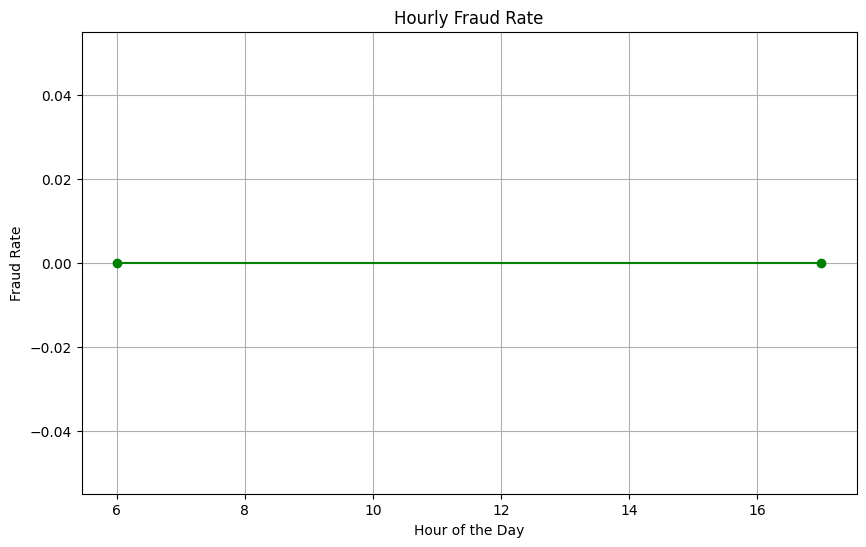

In [17]:
# 데이터 불러오기 (데이터 프레임 생성)
data = {
    'index': [0, 1, 2, 3, 4],
    'Amount': [134.09, 38.48, 120.34, 128.95, 104.71],
    'Datetime': ['2002-09-01 06:21:00', '2002-09-01 06:42:00', '2002-09-02 06:22:00', '2002-09-02 17:45:00', '2002-09-03 06:23:00'],
    'Use Chip': ['Swipe Transaction', 'Swipe Transaction', 'Swipe Transaction', 'Swipe Transaction', 'Swipe Transaction'],
    'Is Fraud?': [0, 0, 0, 0, 0],
    'Time': ['06:21', '06:42', '06:22', '17:45', '06:23'],
    'Merchant City': ['La Verne', 'Monterey Park', 'Monterey Park', 'Monterey Park', 'La Verne'],
    'Merchant State': ['CA', 'CA', 'CA', 'CA', 'CA']
}

analyzed_data = pd.DataFrame(data)

# Datetime 열을 datetime 자료형으로 변환
analyzed_data['Datetime'] = pd.to_datetime(analyzed_data['Datetime'])

# 시간대별로 데이터 그룹화
hourly_fraud_rate = analyzed_data.groupby(analyzed_data['Datetime'].dt.hour)['Is Fraud?'].mean()

# 시간대별 사기 거래 비율을 시각화
plt.figure(figsize=(10, 6))
hourly_fraud_rate.plot(kind='line', marker='o', color='green')
plt.xlabel('Hour of the Day')
plt.ylabel('Fraud Rate')
plt.title('Hourly Fraud Rate')
plt.grid(True)
plt.show()
